In [ ]:
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import dotenv as denv
import os
import logging
import matplotlib.pyplot as plt
import geopandas as gpd
denv.load_dotenv()

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()
#config.instance_id='68e83e70-2274-4b70-bc0f-ccae0c20d100'
#config.sh_client_id='a0ef8f11-d0e4-4e4d-b1c5-3a930c600aeb'
#config.sh_client_secret='p>keQ7@u@j{i-.0-__Ct0yGW8h@;QtOgJfkdtx8}'


In [ ]:
username = os.getenv("COPERNICUS_USER")
password = os.getenv("COPERNICUS_PASSWORD")
file = "D:\Downloads\S2B_MSIL2A_20210306T115219_N0214_R123_T28SCA_20210306T142532\S2B_MSIL2A_20210306T115219_N0214_R123_T28SCA_20210306T142532.SAFE\GRANULE\L2A_T28SCA_A020884_20210306T115217\IMG_DATA\R60m\T28SCA_20210306T115219_B12_60m.jp2"
directory = "D:\Downloads\S2B_MSIL2A_20210306T115219_N0214_R123_T28SCA_20210306T142532\S2B_MSIL2A_20210306T115219_N0214_R123_T28SCA_20210306T142532.SAFE\GRANULE\L2A_T28SCA_A020884_20210306T115217\IMG_DATA\R60m\\"
gpds_file = r'C:\Users\Manel\OneDrive - Universidade da Madeira\MasterThesis\LUCAS 2015\LUCAS_Topsoil_2015_20200323-shapefile\LUCAS_Topsoil_2015_20200323.shp'
lucas_copernicus_file = r'C:\Users\Manel\OneDrive - Universidade da Madeira\MasterThesis\LucasCopernicus\LUCAS_2018_Copernicus_polygons.shp'


# Geopandas

In [ ]:
lucas_ds = gpd.read_file(gpds_file)

In [ ]:
lucas_copernicus = gpd.read_file(lucas_copernicus_file)

In [ ]:
plt.figure(figsize=(18,20))
plt.show(lucas_ds)


In [ ]:
(geopandasdataframe).to_crs(epsg= 26390) #changing projection system

In [ ]:
lucas_ds.plot()

In [ ]:
lucas_copernicus[:5000].plot(color='red', edgecolor='red')

In [ ]:
lucas_copernicus.loc[[0],'geometry'].plot() #to plot a single item

# Rasterio testing

### https://rasterio.readthedocs.io/en/latest/quickstart.html

In [ ]:
#dataset = rio.open(file)


## iterate files from the directory to the notebook

In [ ]:
datasets = []
for file in os.listdir(directory):
    datasets.append(rio.open(os.path.join(directory,file)))

In [ ]:
fig = plt.figure(figsize = (15,30))
for i, dataset in enumerate(datasets):
    plt.subplot(6,len(datasets) // 4, i+1)
    plt.title(dataset.name.split("/")[-1][:-4]) #uses the filename as a title
    plt.imshow(dataset.read(1), cmap='pink')
plt.show()

In [ ]:
dataset.crs #Cordinate system see: https://www.nceas.ucsb.edu/sites/default/files/2020-04/OverviewCoordinateReferenceSystems.pdf

In [ ]:
dataset.crs #Cordinate system see: https://www.nceas.ucsb.edu/sites/default/files/2020-04/OverviewCoordinateReferenceSystems.pdf

In [ ]:
band1 = dataset.read(1)

In [ ]:
plt.imshow(band1, cmap='pink')

In [ ]:
plt.show()

In [ ]:
show(band1)

In [ ]:
x,y = (dataset.bounds.left + 100000, dataset.bounds.top - 50000) #gets the positions 100km from east and 50km south of the dataset
row, col = dataset.index(x,y)
band1[row,col] #value of the pixel given by x,y

In [ ]:
dataset.xy(dataset.height // 2,dataset.width//2)

# SentinelPy testing

In [ ]:
from sentinelpy import (
    query_sentinel_hub,
    SentinelProductRequestBuilder,
    RequestQueryBuilder,
    PlatformName,
    QuerySentinelProductsResponse
)


In [ ]:
request = (
    SentinelProductRequestBuilder()
    .with_username(username)
    .with_password(password)
    .with_query(
        RequestQueryBuilder().
        platform_name(PlatformName.SENTINEL_2)
    )
    .build()
)
result = query_sentinel_ub(request, log_level= logging.DEBUG)
assert isinstance(result,QuerySentinelProductsResponse)

print(result.body)

In [ ]:
df = pd.read_csv("D:\Documents\LUCAS.SOIL_corr.csv",low_memory=False)

### get the most important columns
(exclude the spectral info ones)

In [ ]:
cols = df.columns.tolist()[:5] + (df.columns.tolist()[:-87:-1])[::-1]

## Podes escrever o titulo das colunas, adicionar a uma lista e ele reordena com base nas que queres, podes até excluir um titulo que não queiras

In [ ]:
df[cols].to_excel("lucas_2015_corr_filter.xls")

### O nosso core é o eo-learn e como utilizar para fazer datasets e fazer uma pesquisa datasets

### repartição dos dados com os varios packages: eo-learn; solaris; 
Quais das features mais importante sde um dataset/
ver as masks de maneira a retirar apenas o que temos os ground truth
### pipeline: abrir um ds-> buscar o ground truth -> buscar as bandas -> aplicar masks -> alimentar a um feature extractor do eo-learn

In [ ]:
df['NUTS2']

# EO-LEARN related

In [5]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

Dimension of the area is 243184 x 161584 m2


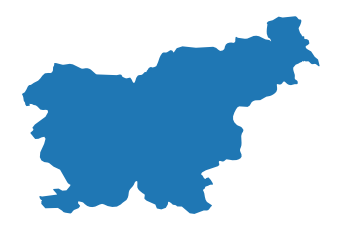

In [6]:
DATA_FOLDER = os.path.join("E:","eo-learn_examples")

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn_border.geojson'))
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [7]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=country.crs,
                           geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(os.path.join(DATA_FOLDER,shapefile_name), driver='GPKG')

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


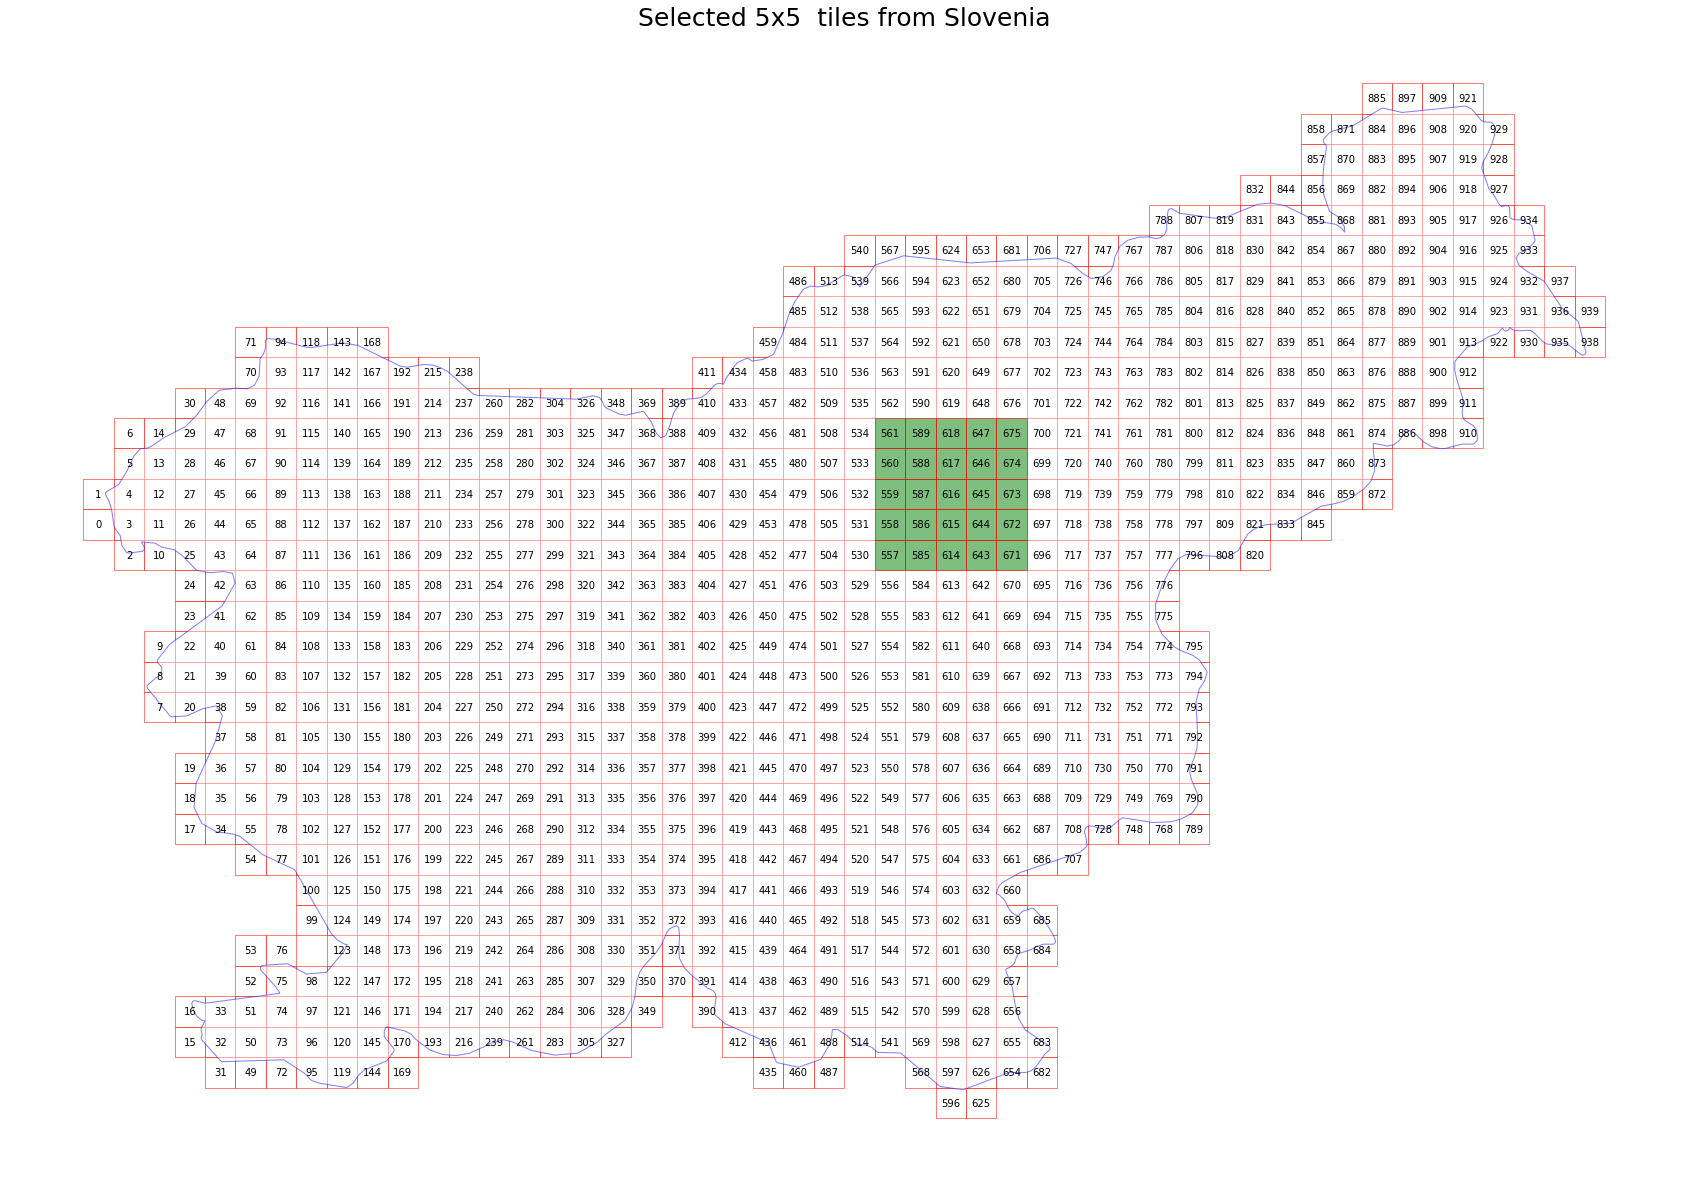

In [8]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from Slovenia', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [9]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# TASK FOR BAND DATA
# add a request for S2 bands
# Here we also do a simple filter of cloudy scenes (on tile level)
# s2cloudless masks and probabilities are requested via additional data
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    max_threads=5
)


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = 'E:/eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# takes some time due to the large size of the reference data
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
land_use_ref = gpd.read_file(land_use_ref_path)

rasterization_task = VectorToRaster(land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\holoviews\operation\datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


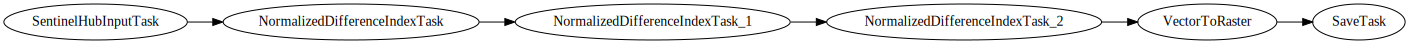

In [14]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    #add_sh_valmask,
   # count_val_sh,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [15]:
%%time

# Execute the workflow
time_interval = ['2019-01-01', '2019-01-02'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/25 [00:00<?, ?it/s]

Wall time: 14.3 s


In [11]:
EOPatch.load('./eopatches/eopatch_0/')


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CreateFailed: root path 'C:\Users\afons\OneDrive\Documentos\JupyterNotebooks\eopatches\eopatch_0' does not exist

In [13]:
FeatureType.DATA

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<FeatureType.DATA: 'data'>